<a href="https://colab.research.google.com/github/kimyejae/CS-374/blob/master/AgeEstimation_yk56_yk62.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# The Effectiveness of Estimating Age Using Face Images </br>
**CS-374-A**: Artificial Intelligence </br>
**Intstructor**: Dr. Kenneth Arnold </br> 
**Author(s):** Yejae Kim and Yena Kim




## **Introduction**

Recently, popular social media platforms have developed “filters” that scans the face of a user and “predicts” / “estimates” the age of that person. “Filters” such as Instagram’s “How Old Do I Look?” are actually accurate, rather it simply uses a random generator to choose the age of a person. In other words, these “filters” are “more of a bit of fun than scientific fact” (Edwards 2020). This project seeks to understand how effective (In this context, the term “effective” is used to signify accuracy and confidence on the predictions made) an intelligent model can be in estimating the age of a person when only provided an image of a face. Understanding that human ageing is differs on several biological, psychological, and socio-economic levels, this project explores whether the model is more accurate in predicting people who are categorized as “White” or people who are categorized as “Non-White.”  Therefore, while the primary purpose of this project is to create an intelligent model that estimates age using face images, this project also tries to tackle the ethics behind Face-Image Datasets, and whether age estimation ought to be used to verify the age of an unaccompanied minor. 




In [ ]:
!pip install -U fastbook torchtext==0.8.1

In [ ]:
# Import fastai Package
import fastbook
from fastai.vision.all import *
from fastbook import *

In [ ]:
# Load Other Packages
from google.colab import drive
from IPython.display import display, Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

In [ ]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **Dataset Description**
 
The UTKFace Dataset (compiled by AICIP [Advanced Imaging and Collaborative Information Processing]) is a large-scale face dataset that consists of over 20,000 face images with an age span ranging from 0 to 116. In addition to the wide `Age` range, the faces in those images also vary in `Gender` and `Ethnicity`. These three variables, `Age`, `Gender`, and `Race` (The variable `Date & Time` is irrelevant to this project) are embedded in the filename, `age_gender_race_date&time.jpg`, where:
-   	`Age`: Integer from 0 to 116.
-   	`Gender`: 0 (Male) or 1 (Female).
-   	`Race`: 0 (White), 1 (Black), 2 (Asian), 3 (Indian), 4 (Others: Hispanic, Middle Eastern, etc.).

Additionally, the images in the dataset cover large variation in “pose[s], facial expression, illumination, occlusion, and resolution.” The authors of the UTKFace Dataset believe the dataset can also be used to train face detection, landmark localization, and age progression / regression models. While the UTKFace Dataset is much smaller than other publicly available face image datasets, the dataset contains more variation that could be useful in training a model for age estimation.  
 
The Asian Face Age Dataset (AFAD) or IMDB-Wiki Dataset are other publicly available face-image datasets that were considered for this project. While both datasets have many more images than UTKFace Dataset, 160,000 and 523,051 respectively, UTKFace Dataset was chosen for the following reasons: 
1. The AFAD only contains “Asian” faces (The images were collected from RenRen Network, a Chinese social networking service. Because RenRen Network is used primarily by Chinese people, the images will mostly contain images from people who are Chinese which would not be helpful in training a model that ought to estimate the age of any person, regardless of their `Ethnicity`.) which limits the scope of the model; 
2. The IMDB-Wiki Dataset is not limited to “Asian” faces, yet the faces are from “celebrities”, stills from movies, and award ceremonies, which, again, limits the scope of the model; 
3. Unlike the IMDB-Wiki Dataset, the images in the UTKFace Dataset are more heterogenous, in terms of the quality of images, facial expressions, and the dataset is not solely comprised of “celebrities” which allows the model to train on a variety of people;
4. The authors of the UTKFace Dataset were more transparent about the owners of the images in the dataset (More on this topic on **Social and Ethical Implications**).
 
Regardless of the strengths and weaknesses of all these three datasets, they all suffer from two common limitation: the age labeled in the images are estimations and some images in all three datasets have watermarks. In the case of UTKFace Dataset, `Age`, `Gender`, and `Ethnicity` are estimated through the DEX Algorithm, which was trained using the IMDB-Wiki Dataset, and double-checked by a human annotator. The images in the IMDB-Wiki Dataset were annotated by humans and the authors of the dataset explicitly state that they “cannot vouch for the accuracy of the assigned age information.” On the other hand, there is no information on how `Age` or other variables were labeled in AFAD. Therefore, it is important to note that the labels in these datasets, especially UTKFace Dataset, could be inaccurate. On the other hand, having watermarks on certain images could mean that the image is a stock-photo. This could also have consequences on how the model is trained.






In [ ]:
# Run ONLY IF Images are NOT in Folder
!tar -xvf "/content/drive/My Drive/Colab Notebooks/part1.tar.gz" -C "/content/drive/My Drive/Colab Notebooks/Images/"

In [ ]:
# Path to Folder with Images 
Path = "/content/drive/My Drive/Colab Notebooks/Images/part1/"

### **Explanatory Data Analysis**

As previously mentioned, the labels (`Age`, `Gender`, `Ethnicity`, and `Date & Time`) of the images is labelled within the name of the file. Looking at the distribution of `Age`, `Gender`, and `Ethnicity`, there are several important characteristics to note before training the model.

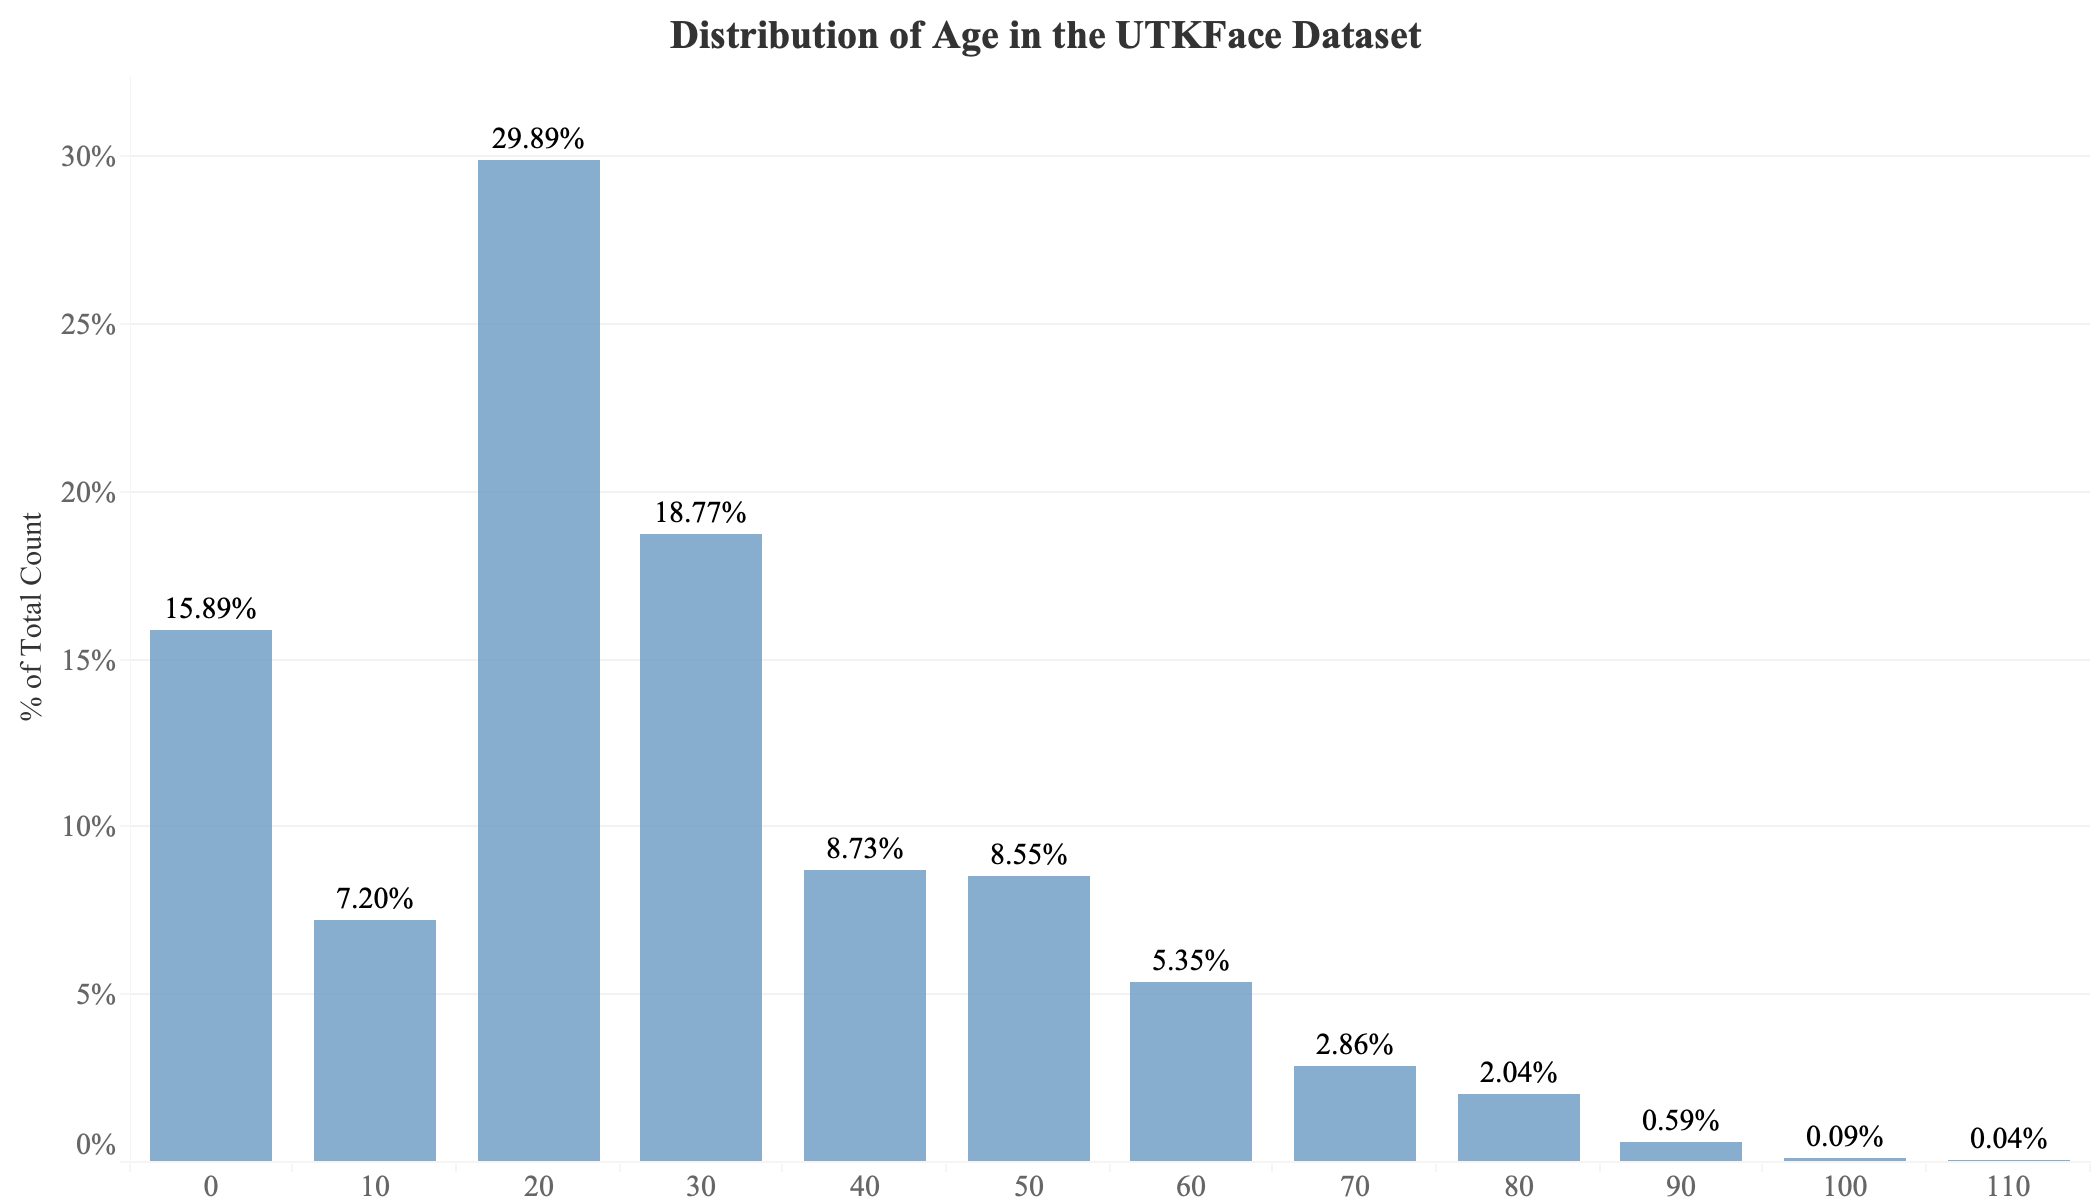

* Looking at `Age`, it is quite evident that the distribution is right-skewed with the `Age` group of 20 having the most images in the dataset (29.89%) followed by the `Age` group of 30 (18.77%) and `Age` group of 0 (Images with ages less than 10) (15.89%). On the other hand, images of `Age` groups 40 and above only comprise 28.25% of the dataset. The lack of data could have implications on the confidence of the model’s estimation of a person greater than or equal to the age of 40.

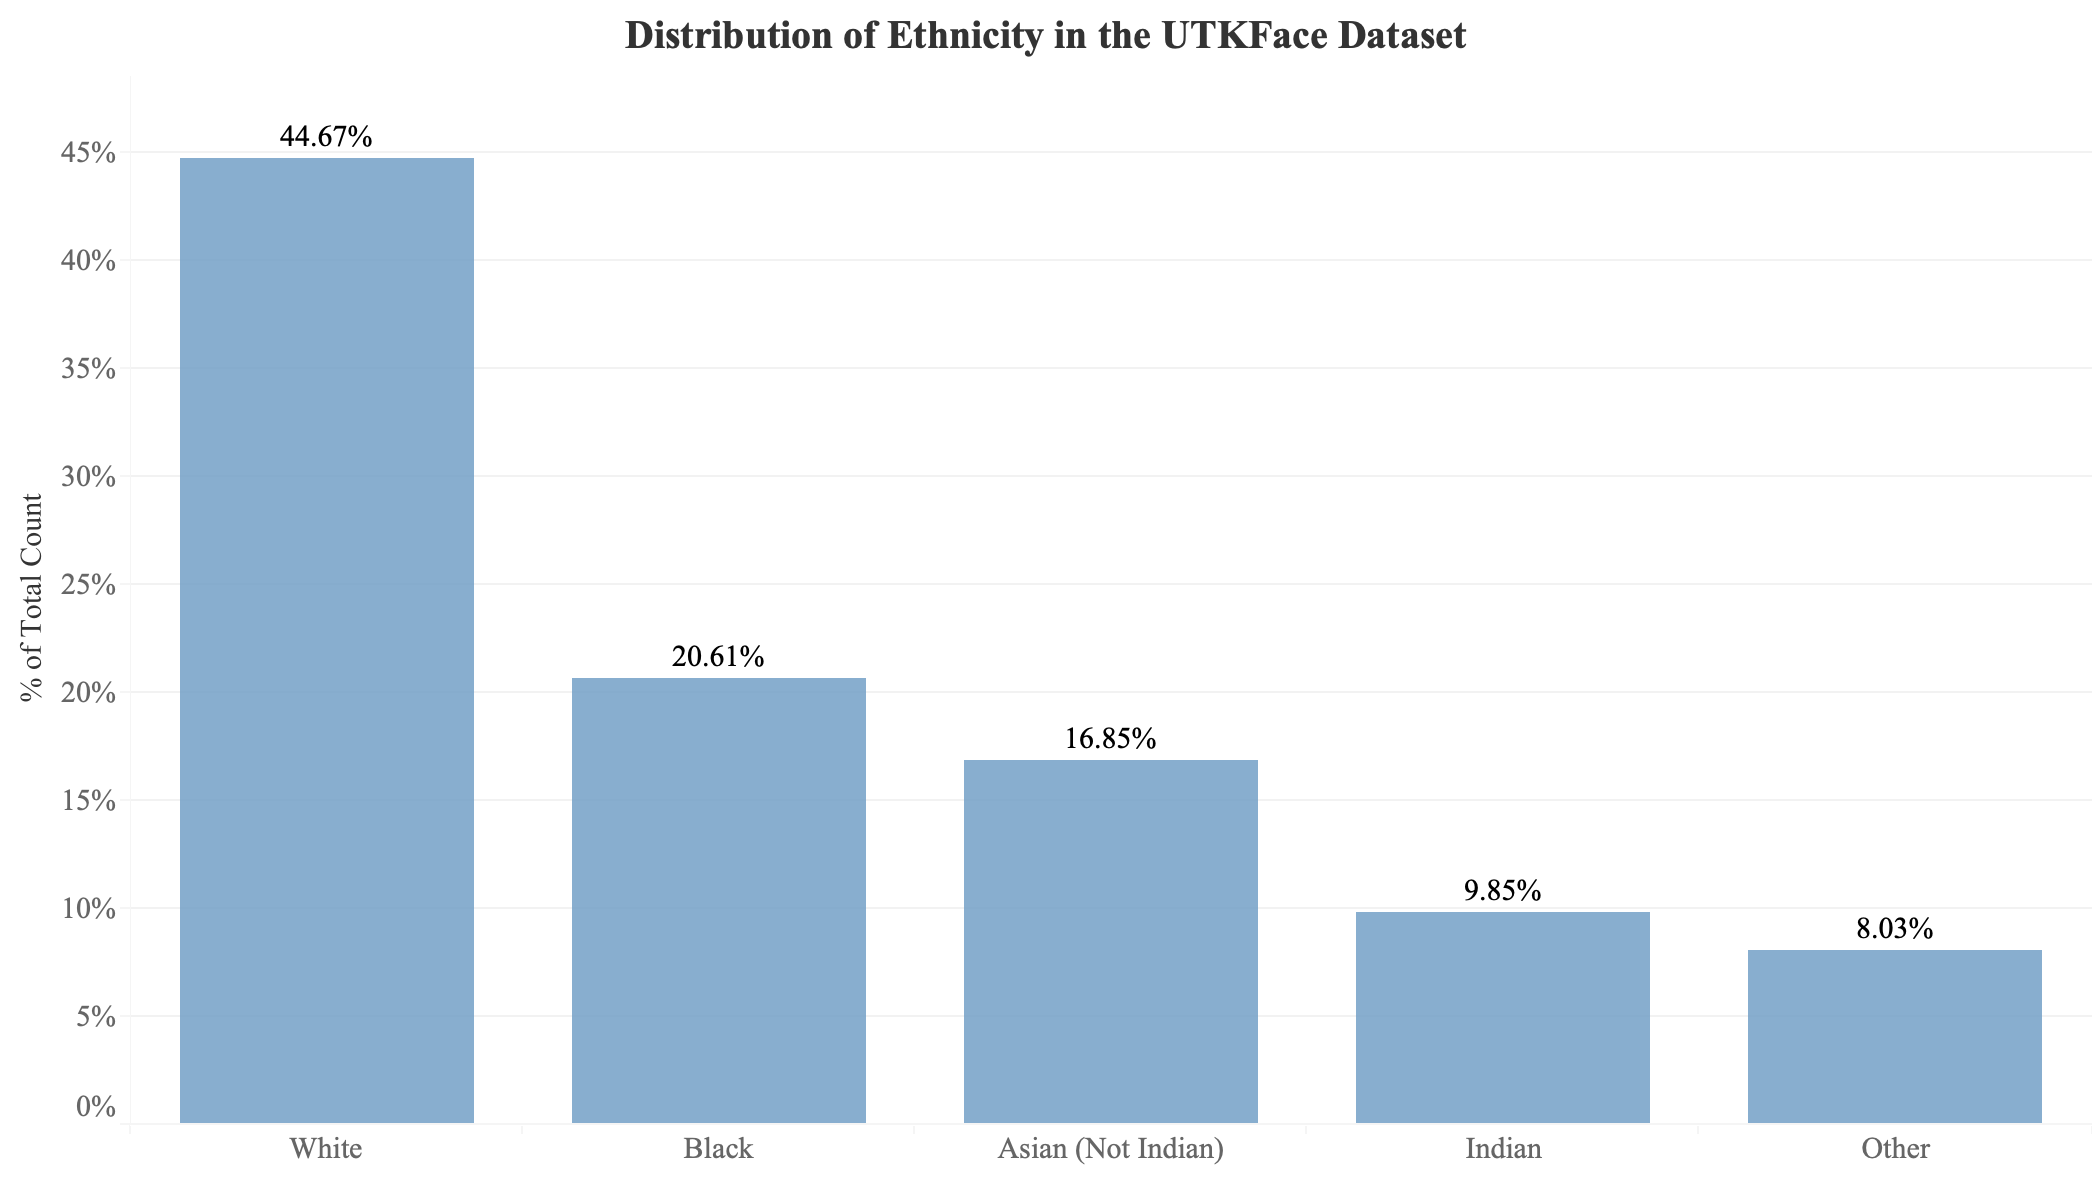

* Similar to the distribution of `Age`, close to 45% of the faces in the dataset are categorized as “White.” On the other hand, the other 55% encapsulates the other four categories of `Ethnicity` (The way AICIP categorized `Ethnicity` is confusing as people from India and the Middle East (with the exception of Egypt, Israel, and Turkey) are Asian and they gave India its own category while putting Middle Easterners in “Others”). While this is not surprising, it is evident that this could lead to “Racial Bias.” In other words, this may cause the model to perform less well on images that are not categorized as “White” (This *hypothesis* will be tested below).

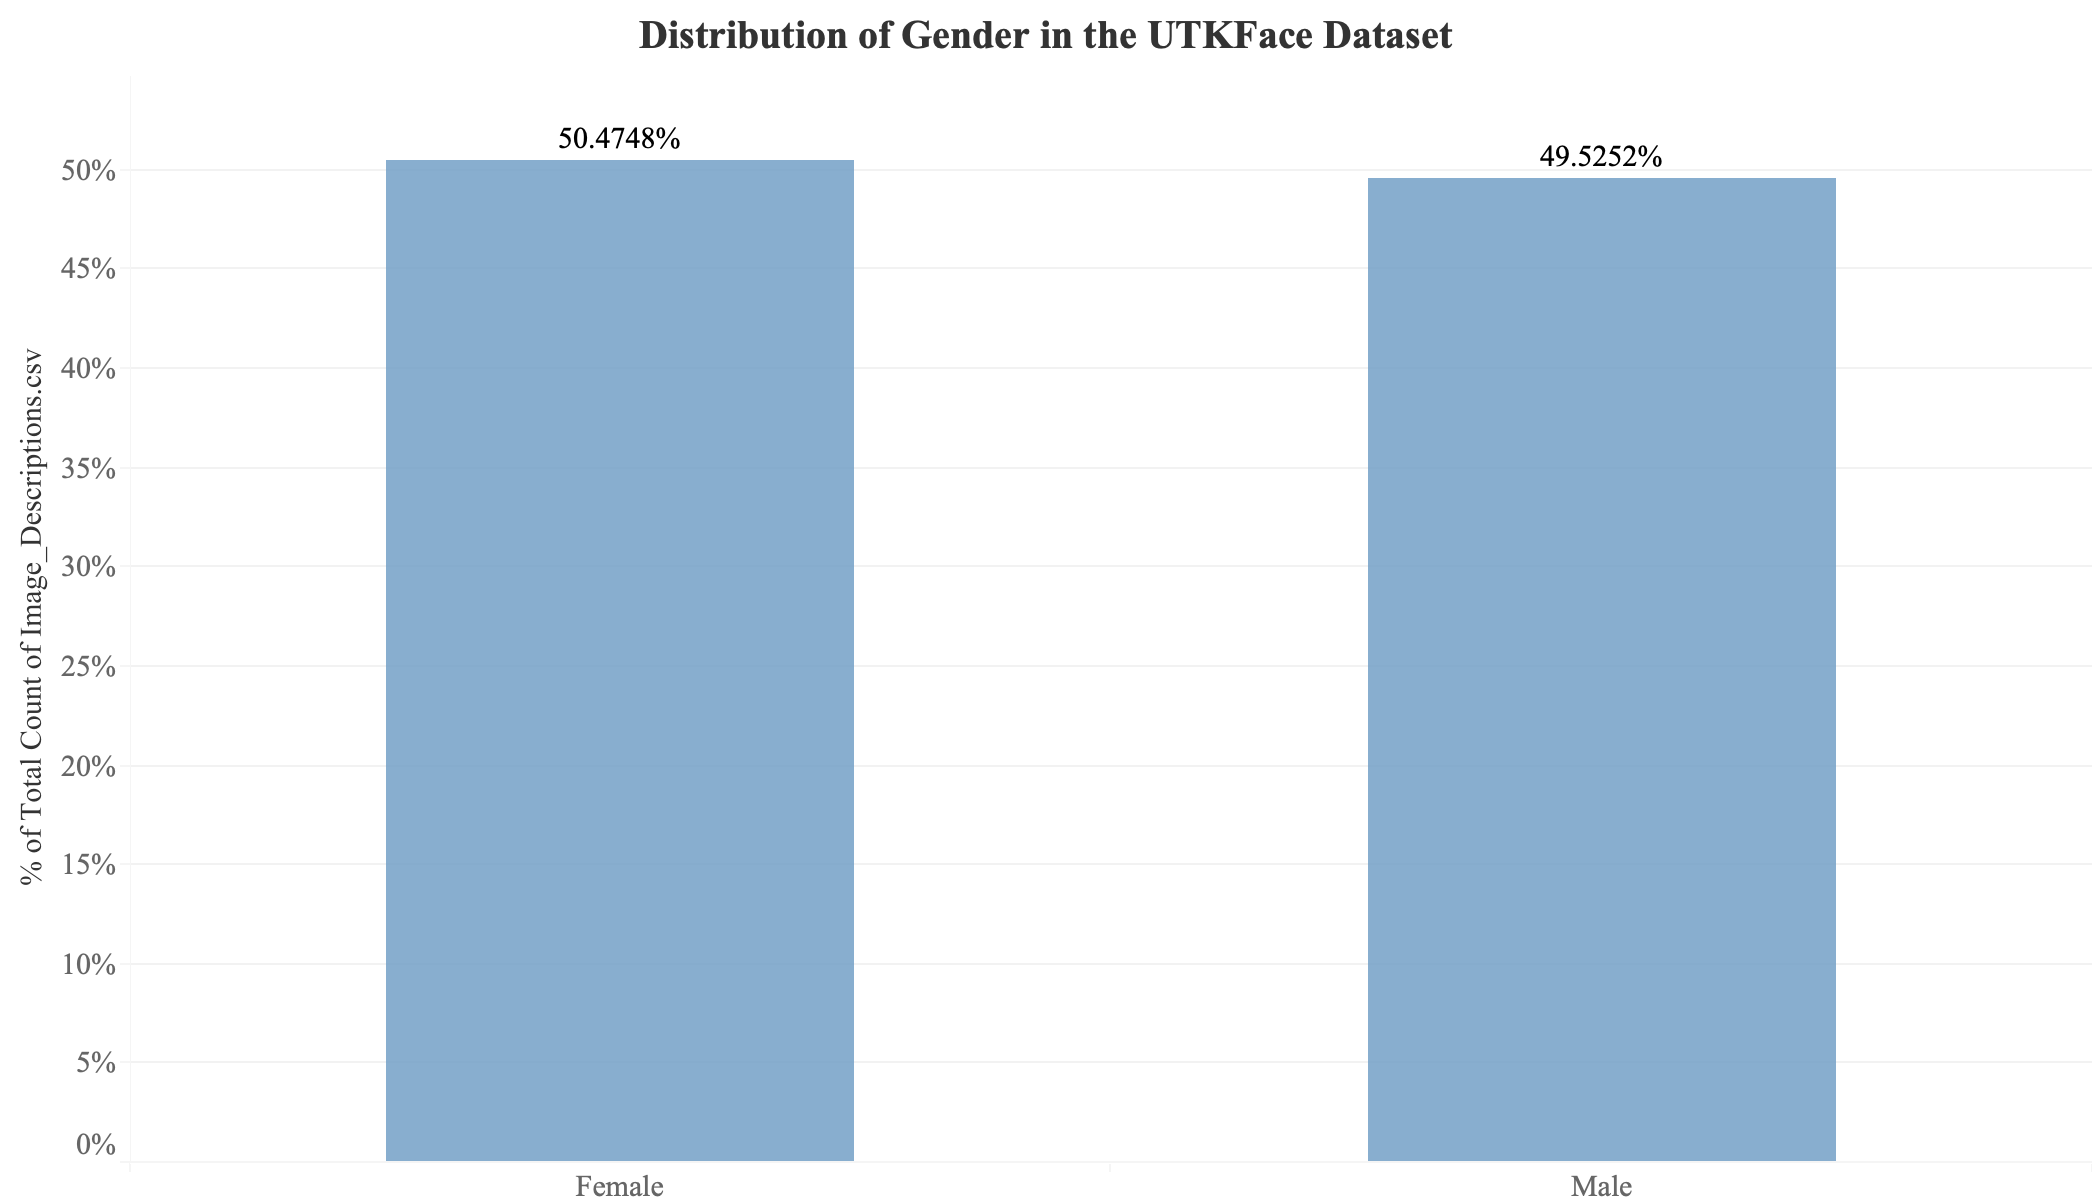

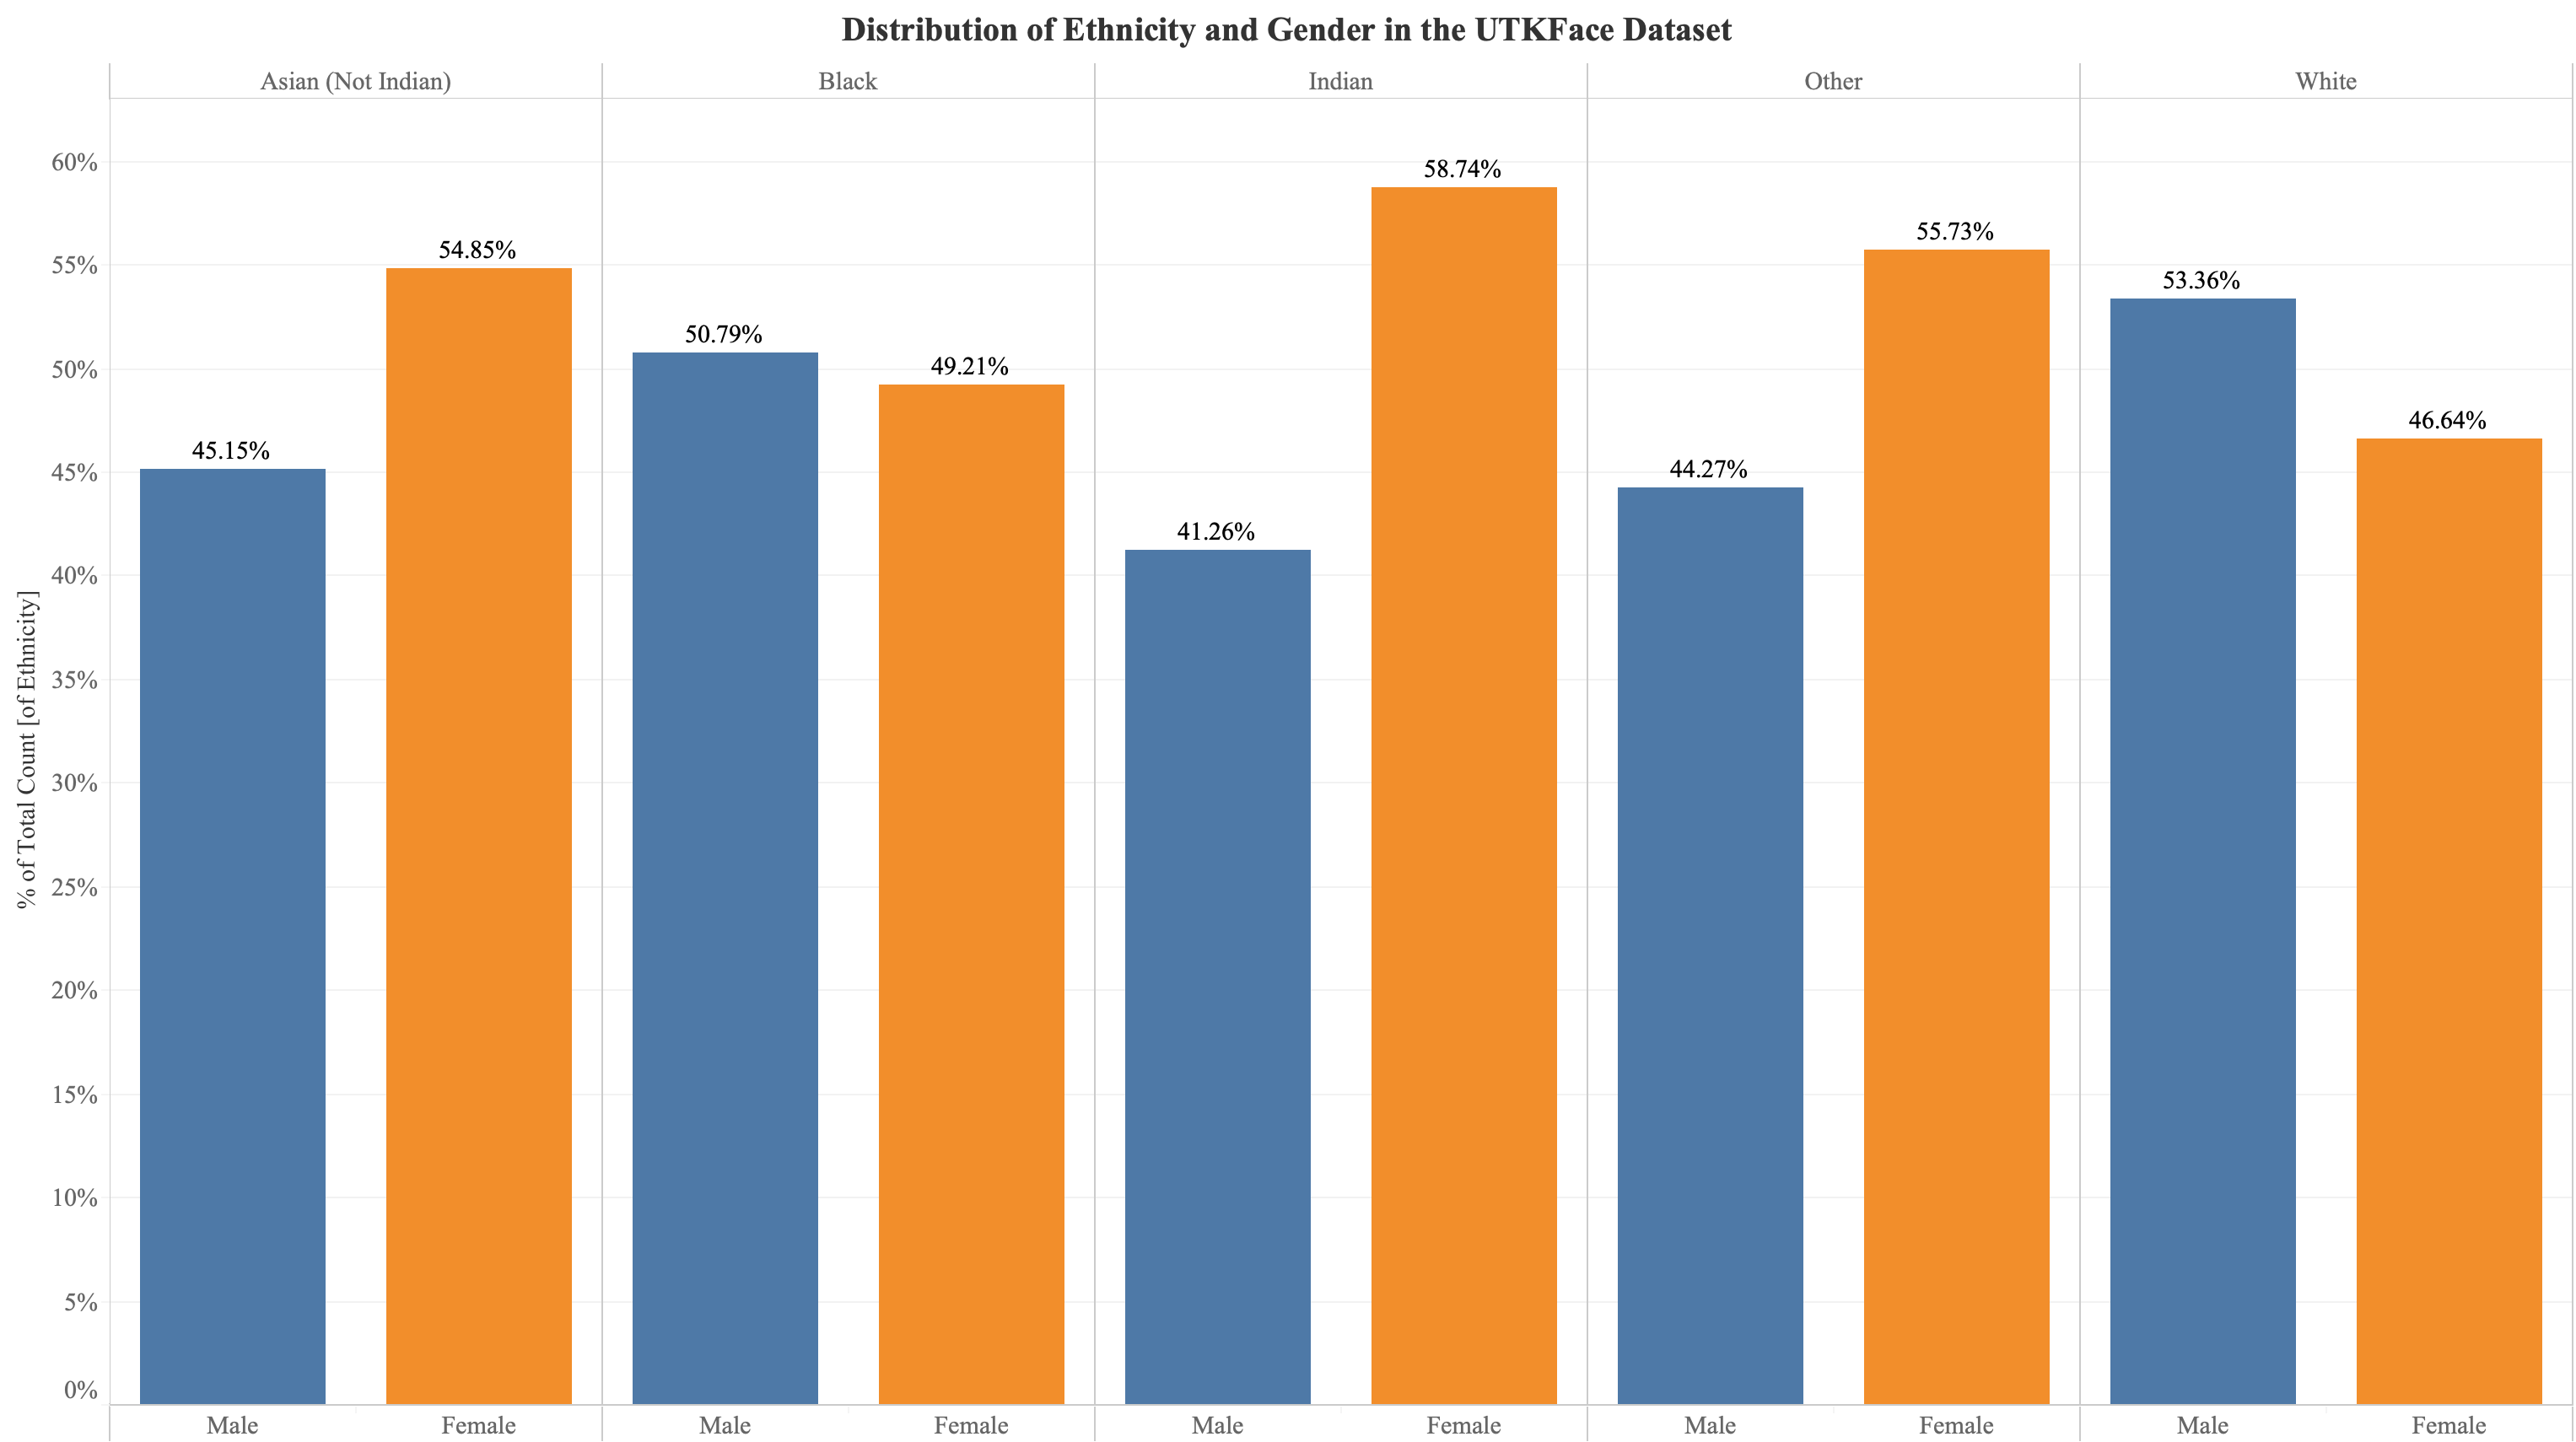

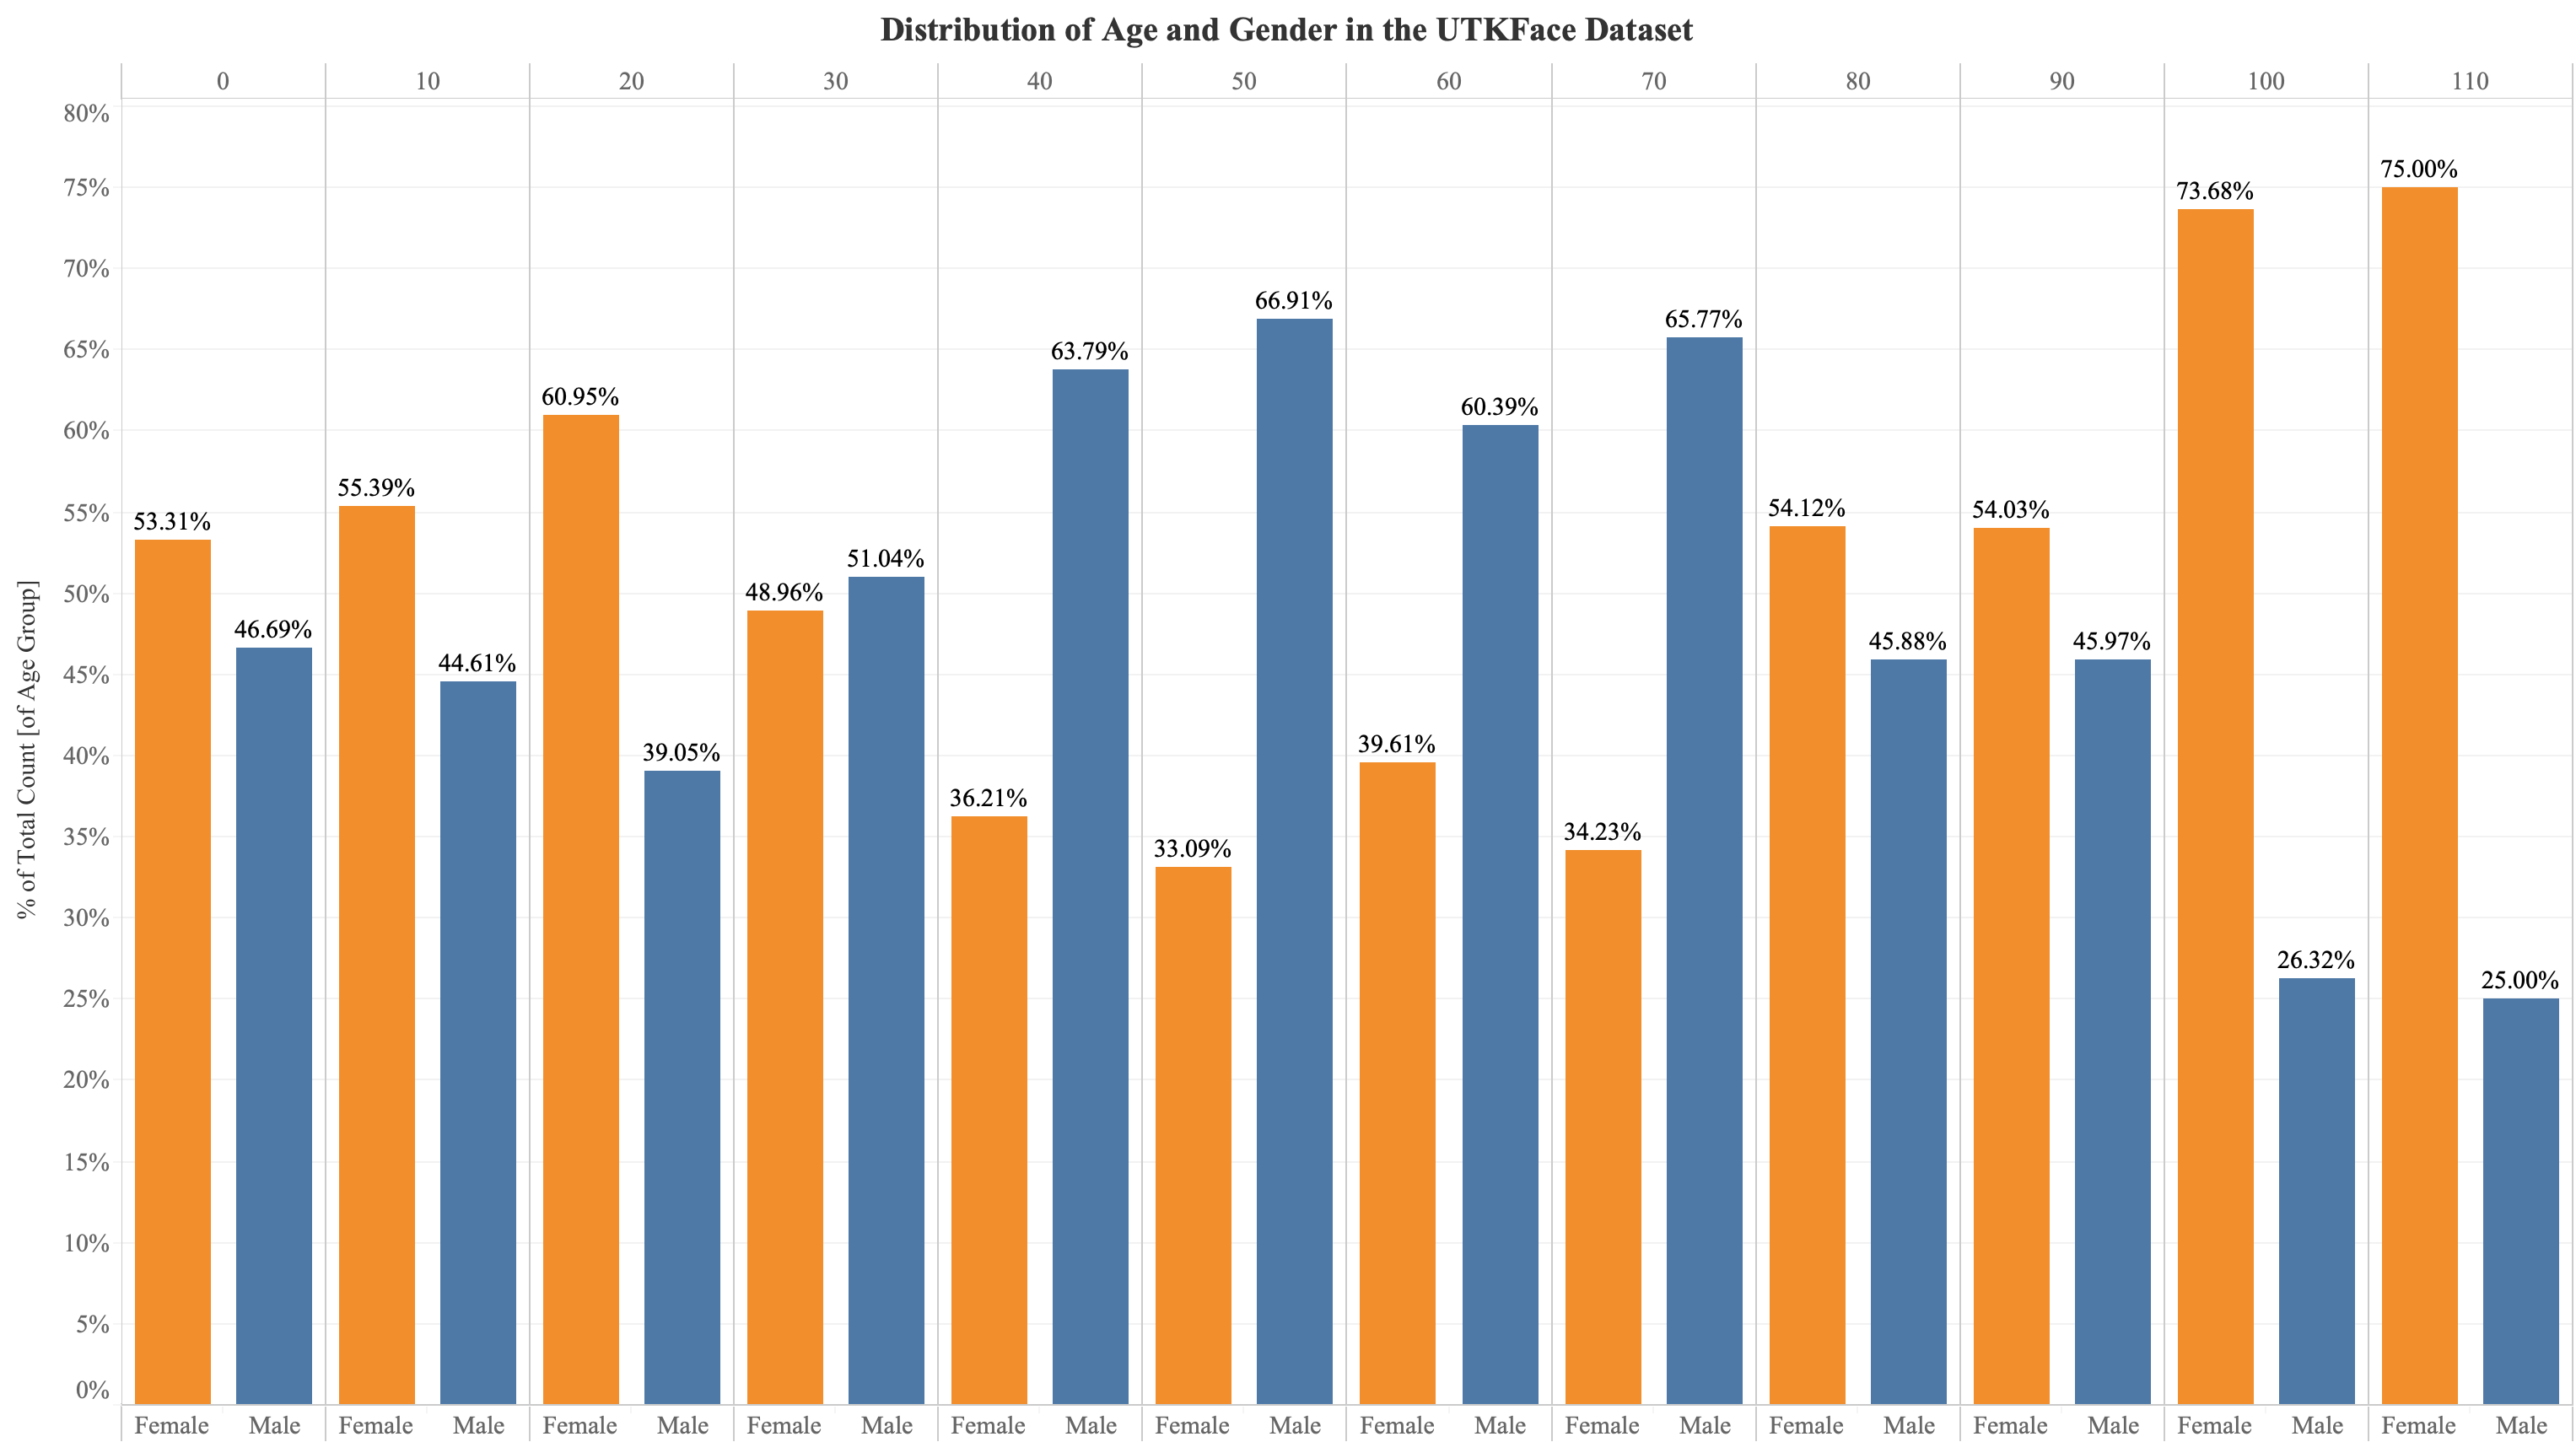

* Lastly, the distribution of `Gender` is not skewed compared to the previous two variables. Looking solely at `Gender`, it is quite clear that both “Male” and “Female” are close to being equally distributed, 50.47% and 49.53%, respectively. Additionally, the distribution of `Gender` seems to be equally distributed between the different categories of `Ethnicity` as well (While there is some variation, all the distributions do not have a proportion greater than 60-40). On the other hand, there is some unequal distribution of `Gender` on different categories of `Age`, especially `Age` categories of 40, 50, 60, and 70. `Age` categories of 100 and 110, while very unequal, are a result of a low number of images in that category which is a cause of concern on itself. Therefore, while `Gender` seems to be equally distributed overall, there is some skewness within `Age` that might lower the accuracy of the model.

## **Modeling Setup**

### **Technical Approach** 

Overall, this project will use Google Colab to facilitate collaboration and use `FastAI` to build and train the models for this project. In addition to FastAI, this project utilizes `Pandas` for any data manipulation / wrangling utilized in this project and `Matplotlib` for any visualizations shown in this notebook (with the exception of the **Exploratory Data Analysis** visualizations).

The first step in creating an intelligent model that estimates age is to prepare the data that will be used to *train* the model and *test* the "effectiveness" of the model as well. Because the labels of the images are embedded on the filename (`age_gender_race_date&time.jpg`), the `image_age` function extracts the `Age` from the filename. Having written a function that extracts the `Age` from the filenames, then can the whole dataset be labelled before training the *simple* model. For the *alternate* model, we extract the `Age` from the filename then label them to an `Age Category` depending on the age.

The second step of this project will be to create a *simple* model to get an understanding of what the baseline results look like. In this project, the *simple* model will refer to the model where the dependent variable is `Age`, which ranges from 0 to 116. The *alternative* model will refer to the model where the dependent variable is `Age Categories` instead. The reasoning behind this is the following: When the dependent variable is just `Age`, it is most likely that the `error_rate` will be high because predicting the exact age of a a person in a similar age group where people look alike is hard. Therefore, grouping the `Ages` allows for the model to predict a lower number of categories instead of an integer from 0 to 116 which hopefully will improve the `error_rate`. 

For this project, `ResNet34` will be the architecture that will be used to train the models. `ResNet34` is also used because it is both fast and accurate for most datasets and problems. Additionally, `ResNet34` is the most compatible with the free version of Google Colab. As mentioned above, both the *simple* and *alternate* model will consist of the following features:

* Training and Validation Set (70% and 30%, respectively);
* Resize Images to 224 by 224 pixels (Because there is no documentation that the images in the dataset are the same size, the `Datablock` explicitly resizes the images as they need to be the same size to go through the model);
*  The Learning Rate is calculated to prevent many epochs to train the model which also prevents overfitting. After finding the Learning Rate, the weights of the pretained *simple* model will be fine-tuned.
* The `error_rate` will be the *metrics* for this project as one of the purposes of this project is to optimize the accuracy of the model.

### **Data Wrangling**

In [ ]:
from fastai.vision import *

In [ ]:
images = get_image_files(Path)

In [ ]:
sample_image = images[28]

In [ ]:
sample_image = open_image(sample_image)

NameError: ignored

In [ ]:
# Define Function for Age
def image_age(x):
  age = x.split("_")[0]
  return age

In [ ]:
# Create Splitter Object with 30% Validation Set
splitter = RandomSplitter(valid_pct = 0.3, seed = 42)

In [ ]:
get_Y = lambda file_path: image_age(file_path.name)

### **Create *Simple* Model**

In [ ]:
# Create a DataBlock
age = DataBlock (
    blocks    = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter  = splitter,
    get_y     = get_Y,
    item_tfms = Resize(224),
    batch_tfms=aug_transforms(mult=2)
)

dls = age.dataloaders(Path)

In [ ]:
# Train Model
learn = cnn_learner(dls, 
                    resnet34, 
                    metrics = error_rate)

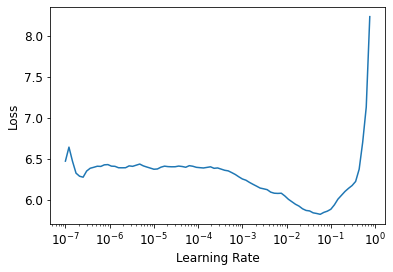

In [ ]:
# Plot Learning Rate Over Loss
lr_min, lr_steep = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 5.75e-03, steepest point: 9.12e-03


epoch,train_loss,valid_loss,error_rate,time
0,5.772574,4.258025,0.854653,01:49
1,4.827436,3.664593,0.821769,01:48
2,4.186702,3.399360,0.797435,01:52
3,3.795472,3.324150,0.797764,01:50
4,3.589734,3.262160,0.794475,01:50
5,3.491523,3.242107,0.789543,01:49
6,3.431698,3.240268,0.793818,01:49


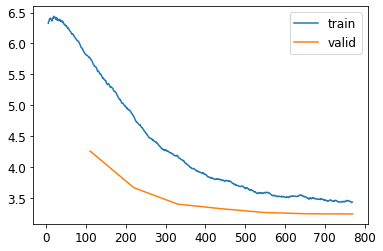

In [ ]:
# Fine-Tune Pretrained Model with the Previously Selected Learning Rate
learn.fit_one_cycle(7, lr_min/10)
# Show Convergence of the Model
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn) 
# Show Predictions with More than 10 Wrong Predictions
interp.most_confused(min_val=10)

[('2', '1', 72),
 ('1', '2', 42),
 ('3', '2', 25),
 ('3', '1', 18),
 ('4', '3', 18),
 ('10', '9', 14),
 ('22', '26', 13),
 ('16', '9', 11),
 ('18', '16', 11),
 ('23', '21', 11),
 ('26', '24', 11),
 ('5', '4', 11),
 ('85', '75', 11),
 ('24', '21', 10),
 ('24', '26', 10),
 ('4', '1', 10),
 ('4', '2', 10),
 ('8', '9', 10)]

### **Analysis of Results (*Simple* Model)**

Looking at the results of the *Simple* Model, the `error_rate` was 79.9%, which is quite high. This means that the “accuracy” of this model, which in this context will be 1 - `error_rate`, was 21.1%. In other words, only 21.1% of the predictions were correct. While in other models this would be a cause of concern, it is important to remember that people do not look drastically different when they have similar ages. Therefore, looking at the "table" above, most of the "wrongfully" classfied images had close predictions. 

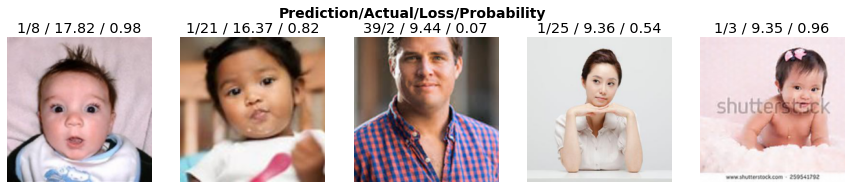

In [ ]:
interp.plot_top_losses(5, nrows=1)

While this will be mentioned below, looking at the images with the highest "Loss" values, there are images that were misclassfied in the dataset. In the explanation of the UTKFace Dataset, the images were labelled using an algorithm and human coders. One can assume that there would not be any drastic mistakes, yet there are some images that seem to be very wrong in terms of their `Age` labels.

### **Create *Alternative* Model**

In [ ]:
# Define Age as Categories
# Categories from the Canadian Census
def image_age_categories(x):
  age = int(x.split("_")[0])
  if age <= 14:                  return "Children"
  elif age > 14 and age <= 24:   return "Youth"
  elif age > 24 and age <= 64:   return "Adult"
  elif age > 64:                 return "Senior"

In [ ]:
get_Y = lambda file_path: image_age_categories(file_path.name)

In [ ]:
# Create a DataBlock
age = DataBlock (
    blocks    = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter  = splitter,
    get_y     = get_Y,
    item_tfms = Resize(224),
    batch_tfms=aug_transforms(mult=2)
)

dls = age.dataloaders(Path)

In [ ]:
# Train Model
learn = cnn_learner(dls, resnet34, metrics = error_rate)

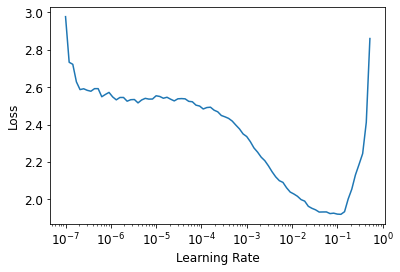

In [ ]:
# Plot Learning Rate Over Loss
lr_min, lr_steep = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest point: 1.20e-03


epoch,train_loss,valid_loss,error_rate,time
0,1.371664,0.750605,0.255179,01:49
1,1.006126,0.628551,0.234134,01:49
2,0.763088,0.559849,0.221309,01:51
3,0.643817,0.520113,0.211444,01:49
4,0.580508,0.496344,0.201250,01:49
5,0.537201,0.496581,0.203551,01:49
6,0.527624,0.488938,0.201907,01:49


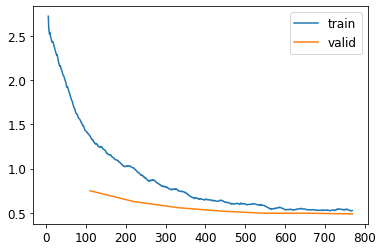

In [ ]:
# Fine-Tune Pretrained Model with the Previously Selected Learning Rate
learn.fit_one_cycle(7, lr_min/10)
# Show Convergence of the Model
learn.recorder.plot_loss()

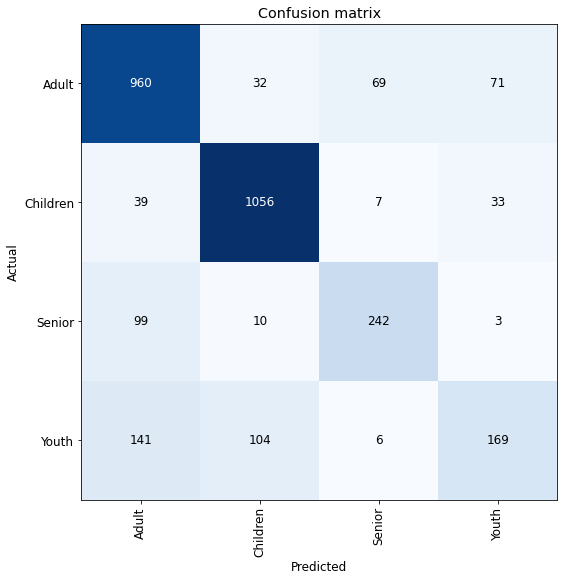

In [ ]:
interp = ClassificationInterpretation.from_learner(learn) 
# Plot Confusion Matrix
interp.plot_confusion_matrix(figsize = (8, 8))

### **Analysis of Results (*Alternative* Model)**
 
Understanding that predicting an exact age of a person results in a high `error_rate`, which is not bad in this context, the *Alternative* Model uses groups `Ages` into categories to account for the fact that physical appearance does not change drastically from one year to another. Yet, these categories will also face a similar problem as the ages in the limits of the categories will be similar to those of the limits of other categories. As the previous model, the same process will be used to train the model and find a good learning rate to train the model.  
 
Instead of using the raw age, using categories of age increased the accuracy of the model dramatically. The `error_rate` for this model was 20.2% which meant that there was one wrong prediction out of every four images. Again, these categories are broad and physical appearances overlap between categories so it makes sense that there would be some wrongly categorized images. This reinforces the idea that the process or the phenomenon of ageing is quite complex and the model rarely wrongly categorized totally different age groups.

Overall, the relatively simple models that were created for this project might not be adequate to properly estimate age. Because the model was trained on images with a variety of factors, maybe creating models with one ethnicity or gender might have better results, in terms of `error_rate`.
 





## **Model with Trained with Only "White" Images**

In [ ]:
# Extract Only Images with "White" Faces
def get_image_files_subset(x):
  image_files = sorted(get_image_files(Path))

  image_file_subset = []

  for x in range(len(image_files)):
    if image_files[x].name.split("_")[2] == '0':
      image_file_subset.append(image_files[x])

  return image_file_subset

In [ ]:
# Create a DataBlock
age_White = DataBlock (
    blocks    = (ImageBlock, CategoryBlock),
    get_items = get_image_files_subset,
    splitter  = splitter,
    get_y     = get_Y,
    item_tfms = Resize(224),
    batch_tfms=aug_transforms(mult=2)
)

dls_White = age_White.dataloaders(Path)

In [ ]:
# Train Model
learn_White = cnn_learner(dls_White, resnet34, metrics = error_rate)

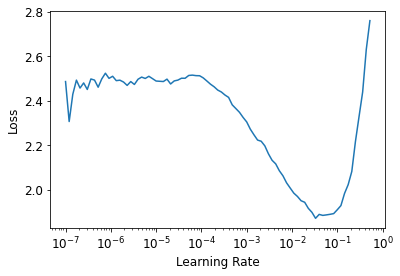

In [ ]:
# Plot Learning Rate Over Loss
lr_min, lr_steep = learn_White.lr_find()

epoch,train_loss,valid_loss,error_rate,time
0,2.057522,0.994735,0.388133,01:12
1,1.486849,0.759852,0.279357,01:12
2,1.248006,0.711765,0.255871,01:13
3,1.090675,0.676862,0.232386,01:12
4,0.984038,0.652551,0.233004,01:12
5,0.930255,0.643677,0.231150,01:13
6,0.929491,0.640575,0.234858,01:13


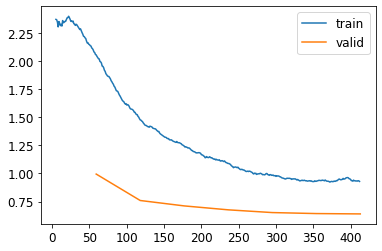

In [ ]:
# Fine-Tune Pretrained Model with the Previously Selected Learning Rate
learn_White.fit_one_cycle(7, lr_min/10)
# Show Convergence of the Model
learn_White.recorder.plot_loss()

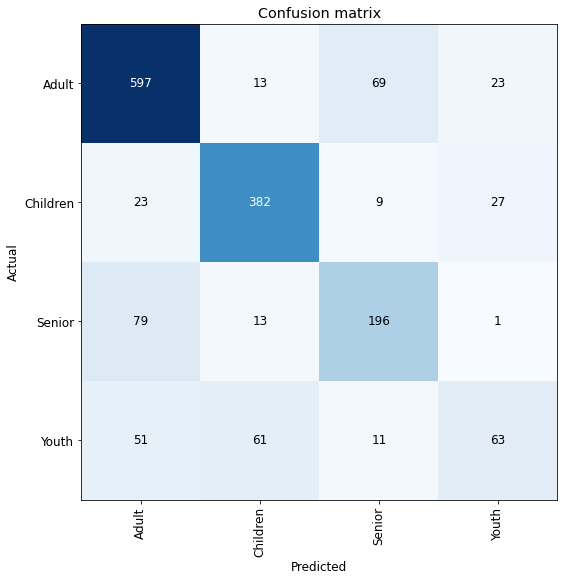

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_White) 
# Plot Confusion Matrix
interp.plot_confusion_matrix(figsize = (8, 8))

*Training* and *Validating* only on images classifed with "White" people did not improve the `error_rate`. While the `error_rate` with only "White" people is slightly worse than the *Alternative* Model, it will be quite interesting to study how to improve this model.

## **Do Levels of Confidence Differ By Race**

### **Confidence on Images with White People**

In [ ]:
# Create List of Only White People
white = get_image_files_subset(Path)

In [ ]:
# Sample Output for a Prediction
learn.predict(str(white[29]))

('Children',
 tensor(1),
 tensor([5.8682e-04, 9.3909e-01, 1.6709e-03, 5.8657e-02]))

In [ ]:
# Use a 10th of the Images
# Using the Whole Set Takes more than 2 Hours
# Predict `learn.predict` Once Instead of Multiple Times
confidence = []

for x in range(int(len(white)/10)):
  image_url = str(white[x])
  if learn.predict(image_url)[0]   == 'Adult':
    confidence_level =  learn.predict(image_url)[2][0]
  elif learn.predict(image_url)[0] == "Children":
    confidence_level = learn.predict(image_url)[2][1]
  elif learn.predict(image_url)[0] == "Senior":
    confidence_level = learn.predict(image_url)[2][2]
  elif learn.predict(image_url)[0] == "Youth":
    confidence_level = learn.predict(image_url)[2][3]

  confidence.append(confidence_level)

In [ ]:
# Calculate Average Confidence of Predictions
np.average(confidence)

0.7403431

### **Confidence on Images of Non-White People**

In [ ]:
non_white = []

for x in range(len(image_files)):
  if image_files[x].name.split("_")[2] != '0':
    non_white.append(image_files[x])

In [ ]:
# Sample Output for a Prediction
learn.predict(str(non_white[60]))

('Children',
 tensor(1),
 tensor([5.2329e-03, 9.8195e-01, 1.7774e-04, 1.2635e-02]))

In [ ]:
# Use a 10th of the Images
# Using the Whole Set Takes more than 2 Hours
confidence = []

for x in range(int(len(non_white)/10)):
  image_url = str(non_white[x])
  if learn.predict(image_url)[0] == 'Adult':
    confidence_level =  learn.predict(image_url)[2][0]
  elif learn.predict(image_url)[0] == "Child":
    confidence_level = learn.predict(image_url)[2][1]
  elif learn.predict(image_url)[0] == "Infant":
    confidence_level = learn.predict(image_url)[2][2]
  elif learn.predict(image_url)[0] == "Senior":
    confidence_level = learn.predict(image_url)[2][3]
  elif learn.predict(image_url)[0] == "Teenager":
    confidence_level = learn.predict(image_url)[2][4]
  confidence.append(confidence_level)

In [ ]:
# Calculate Confidence of Predictions
np.average(confidence)

0.7155423

 
To understand whether the fact that there was a disproportionate number of “White” people in the dataset affects the confidence on the model's prediction, “confidence” was measured on the predictions of “White” people and “Non-White” people. The “confidence” level for “White” people was slightly higher (74%) than the “confidence” on “White” people (72%) despite the fact that there were less images of “Non-White” people to train on. While this is a superficial analysis of a “confidence” measure of predictions made by the *Alernative* Model (and the small sample size might have contributed to this result), this reinforces the `error_rate` above: age is difficult to predict regardless of race. 

## **Application**

In [ ]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

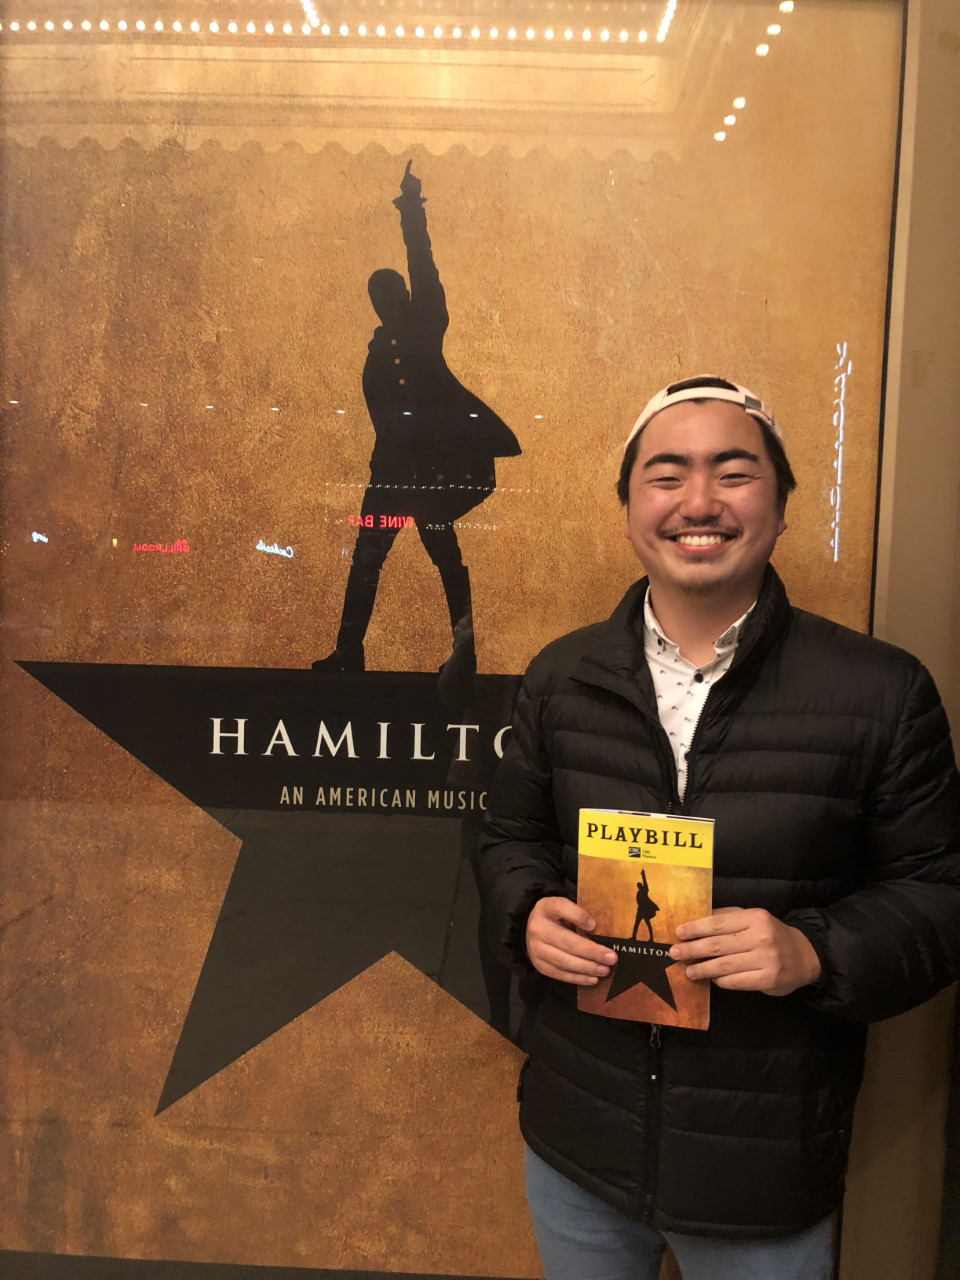

In [ ]:
img

In [ ]:
img = PILImage.create(uploader.data[0])
image_age_category,_, probs = learn.predict(img)
print(f"What Age Category Does the Person Belong To?: {image_age_category}")
print(f"Probability: {probs[1].item():.6f}")

What Age Category Does the Person Belong To?: Children
Probability: 0.539989


## **Limitations and Future Direction**
 
There were three limitations to this project which were (1) the Dataset, (2) Knowledge on Ageing, and (3) Technical Skills. This might sound contradictory as there were two other datasets that could have been chosen for this project, yet as mentioned above, the UTKFace Dataset was believed to be the best available option. Yet, there were several images that were labelled incorrectly that might have affected the model. The disproportionate number of images of people greater than or equal to 40 years old and of people categorized as “White” could have made the model biased (The word “could” is used as the model is not biased with complete certainty). Connected to the topic of bias, having a background on ageing could have enhanced our ability to refine and tune the model to account for biological or physiological traits that are known to be true. While some journal articles and medical articles were consulted for this project, a deeper knowledge on human ageing would have provided more insight in understanding the phenomenon which in turn could have improved the model. Lastly, the lack of experience in coding (especially in Python) proved to be a limitation to estimate the age of a person in real time.
 
The original intention of this project was to create a model that estimated the age of a person in real-time such as Instagram’s “How Old Am I” “filter” which meant trying to estimate the age of a person using the computer’s camera. Despite the failure of accomplishing that goal, it would be an appropriate start to try to figure out how to connect the camera of a user’s computer or phone to estimate the age of that person. Additionally, another direction this project could go towards in the future could be less technical and more focused on the biological and physiological differences of ageing of people from different ethnicities and gender. As mentioned above, there is still a vast void of knowledge on human ageing and why different people age differently. Therefore, it would be interesting to study the different stages of ageing and trying to predict how a person will look like in the future or how a person looked like in the past. Again, there are many applications and “filters” on social media platforms that perform a similar task yet studying the variation of biological and facial features of ageing on different humans could be an interesting direction to take.
 
Lastly, age estimation models should not be used to estimate the age of unaccompanied minors. While an age range estimation is a more preferrable option that estimating an exact age, the stakes are too high for an artificial intelligence model to estimate the age of a person solely on facial features. This cannot be emphasized enough: the process of ageing is unique to every single person. While there has to be measures to verify the age of unaccompanied people to prevent the abuse of immigration system, artificial intelligence models that rely on facial features to estimate age are not the solution. Instead, there should be better immigration policies that provide shelter to all asylum seekers, enforceable international policies that prevent armed conflicts, create sustainable development plans to reduce poverty, and mitigate the effects of nationalism and populism. There might not be a model that could perfectly verify the age of an unaccompanied minor due to the complex nature of ageing, yet effective and appropriate policies could lessen the pain of those who seek help.
